# Описание задачи

В этом сезоне профиля «Искусственный интеллект» НТО вам предстоит поработать с новым форматом данных – видео. В рамках задачи 2 этапа вам нужно разработать алгоритм, который распределит короткие видео (<1 минуты) на 9 заданных классов: 

- animal – в видео присутствует одно или несколько животных;
- car – в видео присутствуют автомобили;
- cloud – в видео показано небо в облаках (тучах);
- dance – в видео есть танцующий человек (люди);
- fire – в видео присутствует пламя (огонь, пламя свечи и т.д.);
- flower – в видео присутствуют цветы;
- food – в видео готовят еду, либо просто присутствует еда;
- sunset – в видео показан закат или рассвет;
- water – в видео показана поверхность воды.

Задачи классификации, к которым относится и эта, являются важнейшим классом задач обучения с учителем (supervised learning). При этом стандартные подходы к классификации изображений могут быть расширены и на видео, которые, по сути, представляют из себя последовательность изображений, распределённых во времени. Задача классификации коротких видеофрагментов имеет широкое практическое применение, а успешные модели могут быть использованы, например, для фильтрации видео-контента или тематической классификации видео, а также в задаче поиска (information retrieval).

**Формат решений**

В проверяющую систему необходимо отправить код алгоритма, запакованный в ZIP-архив. Решения запускаются в изолированном окружении при помощи Docker. Время и ресурсы во время тестирования ограничены: 

- 5Gb на архив с решением
- 25 минут на работу решения

Так как решение не имеет доступ к интернету, все дополнительные данные, например, веса обученной модели, должны быть подгружены в контейнер. В качестве примеры организаторы предоставляют контейнер для запуска бейзлайн-решения.

**Доступные ресурсы:**
- 8 ядер CPU
- 48Gb RAM
- Видеокарта NVidia Tesla V100

**Метрика**

Для оценки решений участников будет использована метрика accuracy, которая показывает долю верно классифицированных объектов выборки.

Метрика accuracy является стандартной метрикой для задач классификации. Она характеризует долю точных совпадений среди пар предсказанных и истинных ответов, то есть отражает отношение числа совпавших ответов (когда модель участника предсказала такой же ответ, как истинный) к общему числу ответов (независимо от того, в определении какого именно класса модель допустила ошибку). Эта метрика изменяется от 0 до 1, где 0 – наихудшее значение, 1 – наилучшее.

**Baseline**

Вам доступно базовое решение от разработчиков задачи с использованием фреймворка PyTorch. 

Предполагаемый пайплайн работы модели включает в себя следующие этапы:
1. вычисление для input видео соответствующих им векторных представлений (эмбеддинги);
2. предсказание для каждого из получившихся эмбеддингов метки (лэйбла) одного из классов.

https://ods.ai/competitions/nto22-23/data

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 472 kB/s 


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 33.4 MB/s 
     |████████████████████████████████| 182 kB 67.3 MB/s 


In [ ]:
import os
import sys
import re
import gc
import platform
import random
import argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import einops

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
import glob
import cv2

from numpy import array
from numpy import argmax

from tqdm import tqdm

import warnings

warnings.simplefilter('ignore')

In [ ]:
# Монтирует google disk в colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
url = os.chdir(r"/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/нто БД/БД второй тур (командный)")
os.getcwd()

'/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/нто БД/БД второй тур (командный)'

In [ ]:
os.listdir('train_video/')

In [ ]:
def read_video(path, img_size, transform=None, frames_num=6):
    frames = []
    cap = cv2.VideoCapture(path)

    fps = int(cap.get(cv2.CAP_PROP_FPS)) # число кадров в секунду
    print(fps)

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # количество кадров
    print(length)

    N = length // (frames_num)

    current_frame = 1

    for i in range(length):
        ret, frame = cap.read(current_frame)

        if ret and i == current_frame and len(frames) < frames_num:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # все кадры в BGR (поэтому перводим в RGB)
            frame = cv2.resize(frame, img_size)

            frames.append(frame)
            current_frame += N

    cap.release()
    # print(frames)
    return frames

video1 = read_video('train_video/Sydney_storm_preview.mp4', (224, 224))

50
783


In [ ]:
video1[0].shape

(224, 224, 3)

In [ ]:
from google.colab.patches import cv2_imshow

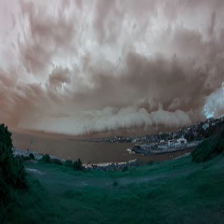

In [ ]:
cv2_imshow(video1[0])

In [ ]:
cls = {'water': 0, 'car': 1, 'cloud': 2, 'food': 3, 'flower': 4, 'dance': 5, 'animal': 6, 'sunset': 7,
       'fire': 8, 'cloud, sunset': 2, 'water, flower': 0, 'cloud, water': 2}

**Про класс DataSet:**

https://habr.com/ru/company/piter/blog/354912/

In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, conf, is_test=False):
        self.conf = conf
        self.df = df
        # последовательность действий по трансформации картинок
        # p - задает вероятность действий
        self.transform = A.Compose([
            ToTensorV2(p=1.0),
        ], p=1.)

        self.is_test = is_test
        self.samples = []
        self.cls = {'water': 0, 'car': 1, 'cloud': 2, 'food': 3, 'flower': 4, 'dance': 5, 'animal': 6, 'sunset': 7,
                    'fire': 8, 'cloud, sunset': 2, 'water, flower': 0, 'cloud, water': 2}
        paths = []
        for path in df.path:
            
            frames = read_video(self.conf['video_path'] + f'/{path}', self.conf['IMG_SIZE'], self.conf['MAX_FRAMES'])
            self.samples += [{'frames': frames}]
            paths.append((path, len(frames),))
        print(f'paths: {paths}')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        print(f'processing item {idx}')
        sample = self.samples[idx]

        frames = sample['frames']

        frames_tr = torch.from_numpy(np.stack(frames, axis=2)).permute(2, 3, 0, 1)

        return frames_tr

In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/нто БД/БД второй тур (командный)/train.csv', index_col=0)

df_train.head()

,path,labels
578,France Argentiere church and cross with Alps_p...,cloud
229,Georgia Okefenokee reflections in scummy water...,water
544,170728_Berlin_A_012_preview.mp4,sunset
369,170209D_039_Diving_1080p_preview.mp4,water
442,motionplaces flower-Oct2018_preview.mp4,flower


In [ ]:
df_train.shape

(522, 2)

In [ ]:
conf = dict(
        MAX_FRAMES=12,
        EPOCHS=5,
        LR=2e-4,
        IMG_SIZE=(224, 224),
        FEATURE_EXTRACTOR='resnext50_32x4d',
        DR_RATE=0.35,
        NUM_CLASSES=12,
        RNN_HIDDEN_SIZE=256,
        RNN_LAYERS=1,
        TEST_BS=4,
        NUM_WORKERS=4,
        # MODEL_PATH=args.weight_path,
        video_path='train_video/'
    )


In [ ]:
%%time
train_data = RSNADataset(df_train, conf)

train_loader = DataLoader(
        train_data,
        batch_size=4,
        shuffle=False,
        num_workers=4
    )

train_loader

In [ ]:
len(train_data.samples[6]['frames'])

6

In [ ]:
train_data.samples[7].keys()

dict_keys(['frames'])

In [ ]:
## Model Class

class ResNextModel(nn.Module):
    def __init__(self, conf):
        super(ResNextModel, self).__init__()
        self.conf = conf
        self.backbone = timm.create_model(self.conf['FEATURE_EXTRACTOR'])

    def forward(self, x):
        return self.backbone(x)


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class RSNAModel(nn.Module):
    def __init__(self, conf, pretrained=True):
        super(RSNAModel, self).__init__()
        self.conf = conf
        self.backbone = ResNextModel(self.conf)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.num_features = self.backbone.backbone.fc.in_features

        self.backbone.backbone.fc = Identity()
        self.dropout = nn.Dropout(self.conf['DR_RATE'])
        self.rnn = nn.LSTM(self.num_features, self.conf['RNN_HIDDEN_SIZE'], self.conf['RNN_LAYERS'], dropout=0.1,
                           batch_first=True, bidirectional=True)  # bidirectional=True
        self.fc1 = nn.Linear(self.conf['RNN_HIDDEN_SIZE'] * 2, self.conf['NUM_CLASSES'])

    def forward(self, x):
        b, f, c, h, w = x.shape
        # print(x.reshape(b * f, c, h, w).shape)
        x = self.backbone(x.reshape(b * f, c, h, w))
        # print(x.shape)
        x = x.reshape(b, f, self.num_features)
        # print(x.shape)
        x, _ = self.rnn(x)
        # print(x.shape)
        x = self.dropout(x[:, -1])  #
        # print(x.shape, self.num_features)
        x = self.fc1(x)
        return x


def main(conf, args, device):
    df_test = pd.read_csv(args.test_path, index_col=0)

    test_data = RSNADataset(df_test, conf)

    test_loader = DataLoader(
        test_data,
        batch_size=conf['TEST_BS'],
        shuffle=False,
        num_workers=conf['NUM_WORKERS']
    )

    model = RSNAModel(conf)
    model.load_state_dict(torch.load(conf['MODEL_PATH']))
    model = model.to(device)

    pred = []
    model.eval()
    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    for batch, frames in prog_bar:
        frames = frames.to('cuda').float()
        with torch.no_grad():
            pred += list(model(frames).argmax(dim=-1).to('cpu').flatten().numpy())

    df_test['labels'] = pred

    os.makedirs(args.output_path, exist_ok=True)
    df_test['labels'].to_csv(args.output_path + 'predictions.csv')


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--test_path', default='./input/test.csv', type=str, help='config path')
    parser.add_argument('--weight_path', default='./weights/model_resnext50_32x4d.pt', type=str, help='config path')
    parser.add_argument('--output_path', default='./output/', type=str, help='config path')
    parser.add_argument('--video_path', default='./video', type=str, help='config path')
    args = parser.parse_args()

    conf = dict(
        MAX_FRAMES=12,
        EPOCHS=5,
        LR=2e-4,
        IMG_SIZE=(224, 224),
        FEATURE_EXTRACTOR='resnext50_32x4d',
        DR_RATE=0.35,
        NUM_CLASSES=12,
        RNN_HIDDEN_SIZE=256,
        RNN_LAYERS=1,
        TEST_BS=4,
        NUM_WORKERS=4,
        MODEL_PATH=args.weight_path,
        video_path=args.video_path
    )

    if torch.cuda.is_available():
        print("Using GPU: {}\n".format(torch.cuda.get_device_name()))
        device = torch.device('cuda')
    else:
        print("\nGPU not found. Using CPU: {}\n".format(platform.processor()))
        device = torch.device('cpu')

    main(conf, args, device)

https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model